In [1]:
from skbio import TreeNode
from io import StringIO

In [2]:
tree1 = TreeNode.read(StringIO("((A:1.0, B:1.0):1.0,(C:1.0, D:1.0):1.0);"))

In [3]:
print(tree1.ascii_art())

                    /-A
          /--------|
         |          \-B
---------|
         |          /-C
          \--------|
                    \-D


In [1]:
from Bio import Entrez, SeqIO
import pandas
import requests
import numpy
from src.matchmatrix import build_matrix
from multiprocessing import Pool
import matplotlib.pyplot as plt
from annoy import AnnoyIndex
from DeepImageSearch import Index, LoadData, SearchImage, config

2021-12-02 11:27:08.969790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 11:27:08.969827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def save_image_by_matrices(name1, name2, seq1, seq2, max_window, min_window):
    matrix = build_matrix(seq1, seq2, max_window, min_window)
    plt.imsave(f"data/images/indelible/{name1}x{name2}.png",(matrix*max_rgb/max_window).astype(numpy.uint8))

In [11]:
max_window = 20
min_window = 1
procs = 4
max_rgb = 255
fasta_file = "data/indelible.fas"
output_path = "data/images/indelible"
input_shape = (2000, 2000, 3)
distance_type = 'euclidean'

In [ ]:
%%time

with open(fasta_file) as handle:
    sequences = SeqIO.parse(handle, "fasta")
    with Pool(procs) as pool:
        pool.starmap(
            save_image_by_matrices,
            [(s.description, s.description, s.seq, s.seq, max_window, min_window) for s in sequences]
        )

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        self.model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')#, pooling="avg")
        # Customize the model to return features from last pool layer
    def extract(self, img):
        # Resize the image
        img = img.resize((input_shape[0], input_shape[1]))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = numpy.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = self.model.predict(x)[0]
        return (feature / numpy.linalg.norm(feature)).reshape((feature.size, 1))
        # Extract Features
    def get_feature(self, image_data:list):
        self.image_data = image_data 
        #fe = FeatureExtractor()
        features = []
        for img_path in self.image_data: # Iterate through images 
            # Extract Features
            try:
                feature = self.extract(img=Image.open(img_path))
                features.append(feature)
            except Exception as e:
                print(e)
                features.append(None)
                continue
        return features

In [5]:
%%time

image_list = LoadData().from_folder([output_path])
vector_index = Index(image_list)
vector_index.FE = FeatureExtractor()
data = vector_index.start_feature_extraction()
f = len(data['features'][0])
t = AnnoyIndex(f, distance_type)
for i, v in zip(data.index, data['features']):
    t.add_item(i, v)
trees = len(data["features"])
print(f"{trees} number of trees")
t.build(trees)
t.save(config.image_features_vectors_ann)
search = SearchImage()
u = AnnoyIndex(search.f, distance_type)
u.load(config.image_features_vectors_ann)

2021-12-02 11:27:36.631299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-02 11:27:36.631361: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-02 11:27:36.631377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-PEBVG10A): /proc/driver/nvidia/version does not exist
2021-12-02 11:27:36.631552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 11:27:38.992053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1024000000 

Image Meta Information Saved: [meta-data-files/image_data_features.pkl]
40 number of trees
CPU times: user 2h 18min 13s, sys: 2min 32s, total: 2h 20min 46s
Wall time: 22min 21s


True

In [78]:
with open(fasta_file) as handle:
    num_seqs = len(list(SeqIO.parse(handle, "fasta")))
df = pandas.DataFrame()
for i in range(num_seqs):
    index_list = u.get_nns_by_item(i, -1, search_k=-1, include_distances=True)
    images = search.image_data.iloc[index_list[0]]['images_paths'].to_list()
    df = pandas.concat([df,
        pandas.DataFrame(
            zip(images, index_list[1]),
            columns=["gene", images[0]]
        ).set_index("gene")
    ], axis=1)
df = df.sort_index(axis=1).sort_index(axis=0)
df.head()

,data/images/indelible/A0xA0.png,data/images/indelible/A1xA1.png,data/images/indelible/A2xA2.png,data/images/indelible/A3xA3.png,data/images/indelible/A4xA4.png,data/images/indelible/A5xA5.png,data/images/indelible/A6xA6.png,data/images/indelible/A7xA7.png,data/images/indelible/A8xA8.png,data/images/indelible/A9xA9.png,...,data/images/indelible/D0xD0.png,data/images/indelible/D1xD1.png,data/images/indelible/D2xD2.png,data/images/indelible/D3xD3.png,data/images/indelible/D4xD4.png,data/images/indelible/D5xD5.png,data/images/indelible/D6xD6.png,data/images/indelible/D7xD7.png,data/images/indelible/D8xD8.png,data/images/indelible/D9xD9.png
gene,,,,,,,,,,,,,,,,,,,,,
data/images/indelible/A0xA0.png,0.000000,0.602917,0.627116,0.644892,0.618600,0.646890,0.635010,0.625876,0.611490,0.622455,...,0.621609,0.624026,0.648056,0.657282,0.642511,0.625585,0.638353,0.633399,0.616272,0.628974
data/images/indelible/A1xA1.png,0.602917,0.000000,0.632816,0.623270,0.646428,0.673746,0.641844,0.640881,0.621867,0.628924,...,0.607129,0.624347,0.650499,0.649347,0.641519,0.632395,0.653042,0.644970,0.631504,0.627528
data/images/indelible/A2xA2.png,0.627116,0.632816,0.000000,0.667881,0.646850,0.681750,0.662854,0.666973,0.654225,0.643372,...,0.647574,0.652189,0.688464,0.695312,0.671328,0.654790,0.665393,0.648841,0.652871,0.653030
data/images/indelible/A3xA3.png,0.644892,0.623270,0.667881,0.000000,0.677469,0.689493,0.660375,0.671558,0.623195,0.653107,...,0.642168,0.641991,0.656113,0.677118,0.656467,0.641346,0.667659,0.676343,0.639793,0.645200
data/images/indelible/A4xA4.png,0.618600,0.646428,0.646850,0.677469,0.000000,0.679412,0.654787,0.650315,0.635720,0.646327,...,0.644400,0.644169,0.671663,0.687073,0.668150,0.645029,0.666414,0.648352,0.647829,0.649621


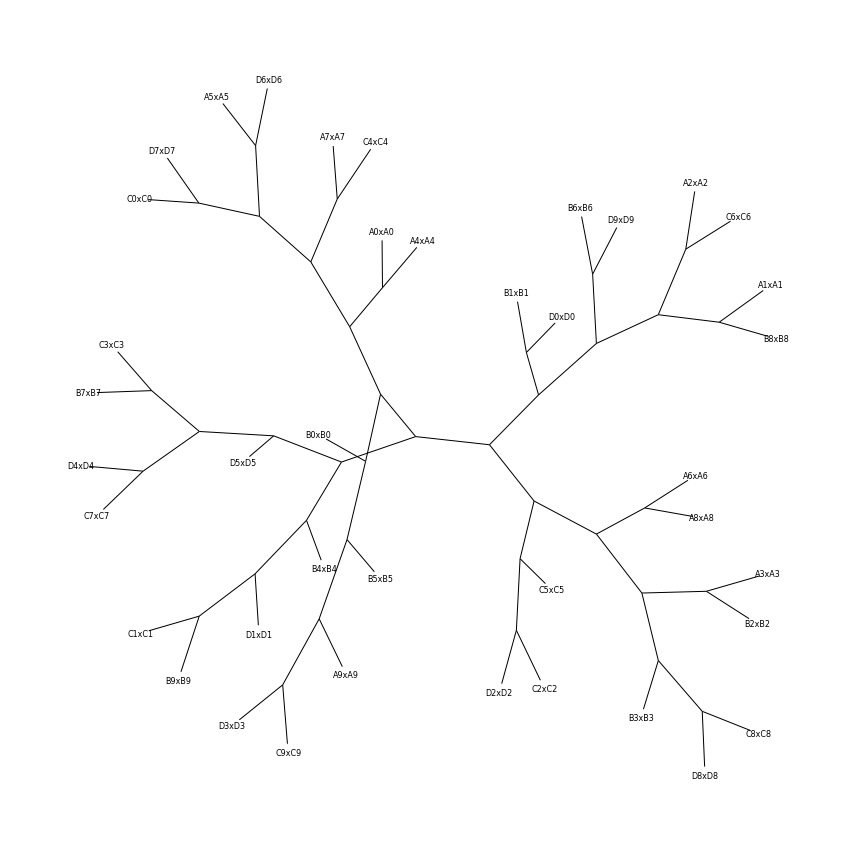

In [7]:
import networkx as nx
import biotite.sequence.phylo as phylo
tree = phylo.neighbor_joining(df.to_numpy())
graph = tree.as_graph().to_undirected()
fig = plt.figure(figsize=(12.0, 12.0))
ax = fig.gca()
ax.axis("off")
pos = nx.kamada_kawai_layout(graph)
node_labels = {i: name.split("/")[-1].split(".")[0] for i, name in enumerate(df.columns)}
nx.draw_networkx(
    graph, pos, ax=ax, labels=node_labels, node_color="white", font_size=8,
    # Draw a white background behind the labeled nodes
    # for better readability
    node_size=[300 if isinstance(node, int) else 0 for node in graph]
)
fig.tight_layout()

plt.show()

In [19]:
import biotite.sequence.io.fasta as fasta
import biotite.application.clustalo as clustalo
import biotite.sequence as seq
import biotite.sequence.align as align

In [69]:
# with open(fasta_file) as handle:
seqs = SeqIO.parse(fasta_file, "fasta")
sequences = []
names = []
for s in seqs:
    sequences.append(seq.NucleotideSequence(s.seq))
    names.append(s.description)
alignment = clustalo.ClustalOmegaApp.align(sequences)

In [24]:
distances = 1 - align.get_pairwise_sequence_identity(
    alignment, mode="shortest"
)

In [25]:
pandas.DataFrame(distances)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000000,0.413333,0.579000,0.609333,0.968333,0.964333,0.966333,0.965667,0.761000,0.754000,...,0.958333,0.960333,0.735333,0.725333,0.713667,0.719333,0.723667,0.728000,0.736000,0.748333
1,0.413333,0.000000,0.587667,0.597333,0.971333,0.965333,0.969333,0.970333,0.757667,0.748667,...,0.964333,0.966667,0.730667,0.727667,0.715000,0.723000,0.739667,0.740667,0.743333,0.746667
2,0.579000,0.587667,0.000000,0.435667,0.967000,0.961667,0.966667,0.965667,0.742000,0.741333,...,0.961333,0.964333,0.712000,0.719667,0.710333,0.716667,0.734667,0.731333,0.740333,0.738333
3,0.609333,0.597333,0.435667,0.000000,0.967333,0.966000,0.967667,0.968667,0.759000,0.746000,...,0.966000,0.963667,0.718000,0.708667,0.716667,0.715667,0.739333,0.742667,0.747000,0.750667
4,0.968333,0.971333,0.967000,0.967333,0.000000,0.415000,0.583333,0.586000,0.964333,0.963000,...,0.701000,0.708333,0.968333,0.968667,0.968000,0.973333,0.960667,0.963000,0.967000,0.964667
5,0.964333,0.965333,0.961667,0.966000,0.415000,0.000000,0.592000,0.589333,0.958333,0.956667,...,0.689333,0.705000,0.966667,0.964333,0.964667,0.968333,0.958000,0.957333,0.959000,0.961333
6,0.966333,0.969333,0.966667,0.967667,0.583333,0.592000,0.000000,0.419667,0.961000,0.960667,...,0.693667,0.696000,0.967667,0.972667,0.969333,0.972667,0.956333,0.959000,0.964333,0.964333
7,0.965667,0.970333,0.965667,0.968667,0.586000,0.589333,0.419667,0.000000,0.960667,0.960000,...,0.696333,0.699333,0.966667,0.969667,0.969333,0.971333,0.951333,0.961000,0.963000,0.964667
8,0.761000,0.757667,0.742000,0.759000,0.964333,0.958333,0.961000,0.960667,0.000000,0.426000,...,0.959333,0.959000,0.740667,0.740667,0.762000,0.751000,0.745000,0.754000,0.744667,0.752667
9,0.754000,0.748667,0.741333,0.746000,0.963000,0.956667,0.960667,0.960000,0.426000,0.000000,...,0.957333,0.956667,0.744667,0.746333,0.765333,0.748333,0.757000,0.749667,0.757333,0.765333


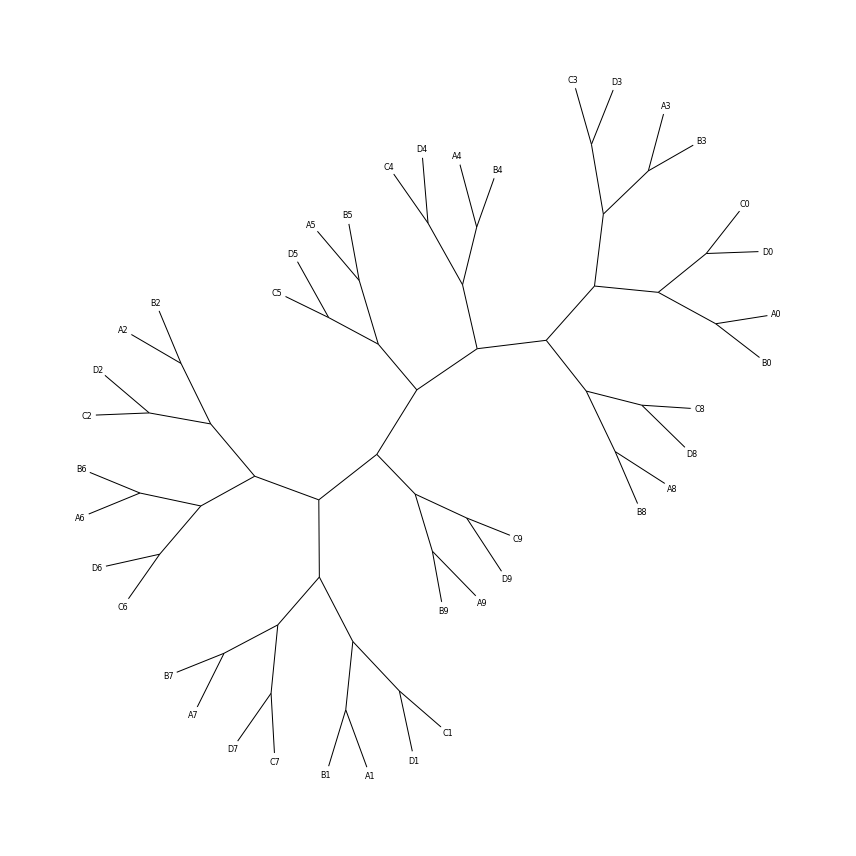

In [26]:
tree = phylo.neighbor_joining(distances)
# Convert to NetworkX graph
#For the graph visualization, the edge directions are unnecessary
graph = tree.as_graph().to_undirected()

fig = plt.figure(figsize=(12.0, 12.0))
ax = fig.gca()
ax.axis("off")
# Calculate position of nodes in the plot
pos = nx.kamada_kawai_layout(graph)
# Assign the gene names to the nodes that represent a reference index
node_labels = {i: name for i, name in enumerate(names)}
nx.draw_networkx(
    graph, pos, ax=ax, labels=node_labels, node_color="white", font_size=8,
    # Draw a white background behind the labeled nodes
    # for better readability
    node_size=[300 if isinstance(node, int) else 0 for node in graph]
)
fig.tight_layout()

plt.show()

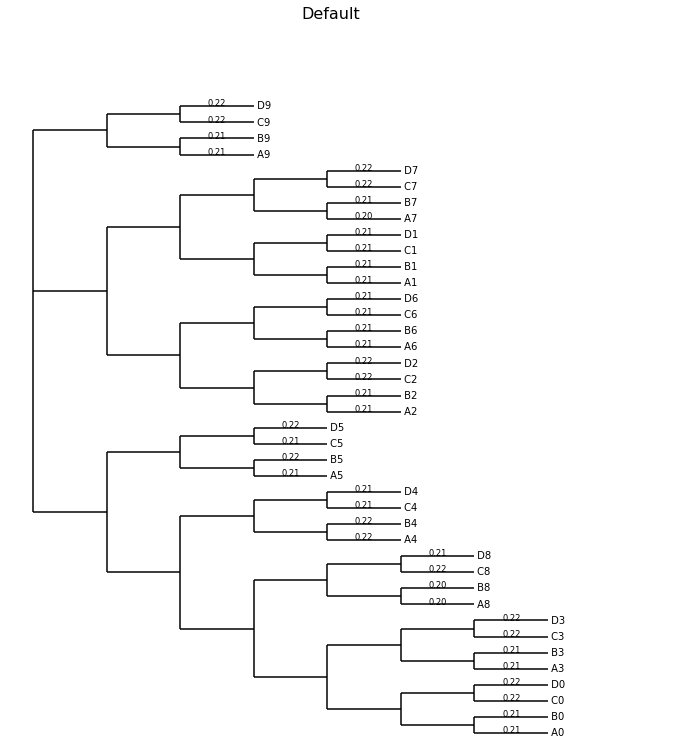

In [67]:
from Bio import Phylo
from io import StringIO

fig = plt.figure(figsize=(12.0, 12.0))
fig.suptitle('Default', fontsize=16)
ax = fig.gca()
ax.axis("off")
t = Phylo.read(StringIO(tree.to_newick()), "newick", values_are_confidence=True)
t.ladderize()
Phylo.draw(
    t,
    show_confidence=True,
    axes=ax,
    do_show=False,
    label_func=lambda clade: "" if not clade.name else names[int(clade.name)],
    branch_labels=lambda clade: "" if not clade.name else "{:.2f}".format(clade.confidence)
)